In [1]:
pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 20.4 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


/usr/local/lib/python3.10/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


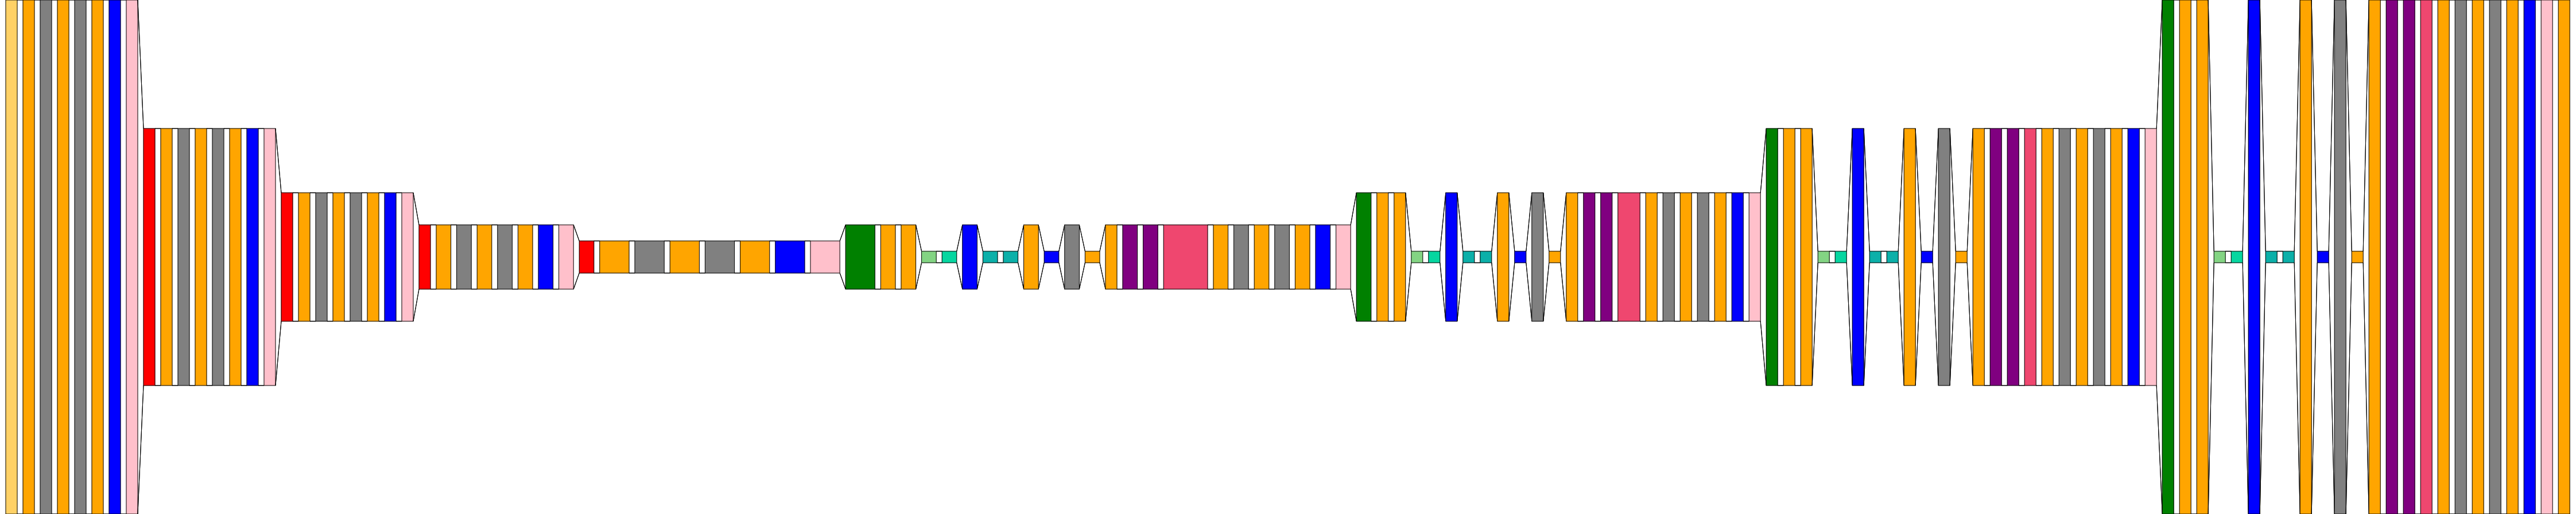

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, Dropout, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Reshape, Multiply, MaxPooling2D, UpSampling2D, concatenate)
from collections import defaultdict
import visualkeras
from PIL import ImageFont, Image

# Enhanced Convolution Block
def enhanced_conv_block(x, filters, ker_init, dropout):
    shortcut = x
    
    # Match channels for residual if needed
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same', kernel_initializer=ker_init)(shortcut)
    
    # Main path
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return Dropout(dropout)(x)

# Enhanced Attention Block
def enhanced_attention_block(x, g, inter_channels):
    # Channel attention
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    
    avg_pool = Reshape((1, 1, inter_channels))(avg_pool)
    max_pool = Reshape((1, 1, inter_channels))(max_pool)
    
    channel_att = Add()([avg_pool, max_pool])
    channel_att = Conv2D(inter_channels, 1)(channel_att)
    channel_att = Activation('sigmoid')(channel_att)
    
    # Spatial attention with gating signal
    theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    f = Add()([theta_x, phi_g])
    
    # Refined spatial attention
    f = Conv2D(inter_channels, 1, padding='same')(f)
    f = BatchNormalization()(f)
    f = Activation('relu')(f)
    spatial_att = Conv2D(1, 1, padding='same')(f)
    spatial_att = Activation('sigmoid')(spatial_att)
    
    # Apply both attention mechanisms
    x = Multiply()([x, channel_att])
    x = Multiply()([x, spatial_att])
    
    return x

# SANet Model
def build_sanet(inputs, ker_init, dropout):
    # Encoder path with enhanced conv blocks
    conv1 = enhanced_conv_block(inputs, 32, ker_init, dropout)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = enhanced_conv_block(pool1, 64, ker_init, dropout)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = enhanced_conv_block(pool2, 128, ker_init, dropout)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = enhanced_conv_block(pool3, 256, ker_init, dropout)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bridge
    conv5 = enhanced_conv_block(pool4, 512, ker_init, dropout)
    
    # Decoder path with enhanced attention
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = enhanced_attention_block(conv4, up6, 256)
    merge6 = concatenate([up6, att6])
    conv6 = enhanced_conv_block(merge6, 256, ker_init, dropout)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = enhanced_attention_block(conv3, up7, 128)
    merge7 = concatenate([up7, att7])
    conv7 = enhanced_conv_block(merge7, 128, ker_init, dropout)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    att8 = enhanced_attention_block(conv2, up8, 64)
    merge8 = concatenate([up8, att8])
    conv8 = enhanced_conv_block(merge8, 64, ker_init, dropout)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    att9 = enhanced_attention_block(conv1, up9, 32)
    merge9 = concatenate([up9, att9])
    conv9 = enhanced_conv_block(merge9, 32, ker_init, dropout)
    
    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    
    return Model(inputs=inputs, outputs=outputs)

# Create the SANet model
inputs = Input(shape=(224, 224, 3))
ker_init = 'he_normal'
dropout = 0.5
sanet_model = build_sanet(inputs, ker_init, dropout)

# Visualization using visualkeras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[BatchNormalization]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Add]['fill'] = 'blue'
color_map[Multiply]['fill'] = 'purple'
color_map[Activation]['fill'] = 'yellow'
color_map[UpSampling2D]['fill'] = 'green'
color_map[concatenate]['fill'] = 'brown'

# Attempt to use the Arial font; fallback if not available
try:
    font = ImageFont.truetype("arial.ttf", 32)
except IOError:
    font = None

visualkeras.layered_view(sanet_model, to_file='sanet.png', color_map=color_map, type_ignore=[Activation])
visualkeras.layered_view(sanet_model, to_file='sanet_legend.png', color_map=color_map, type_ignore=[Activation], legend=True, font=font)
visualkeras.layered_view(sanet_model, to_file='sanet_flat.png', color_map=color_map, type_ignore=[Activation], draw_volume=False)


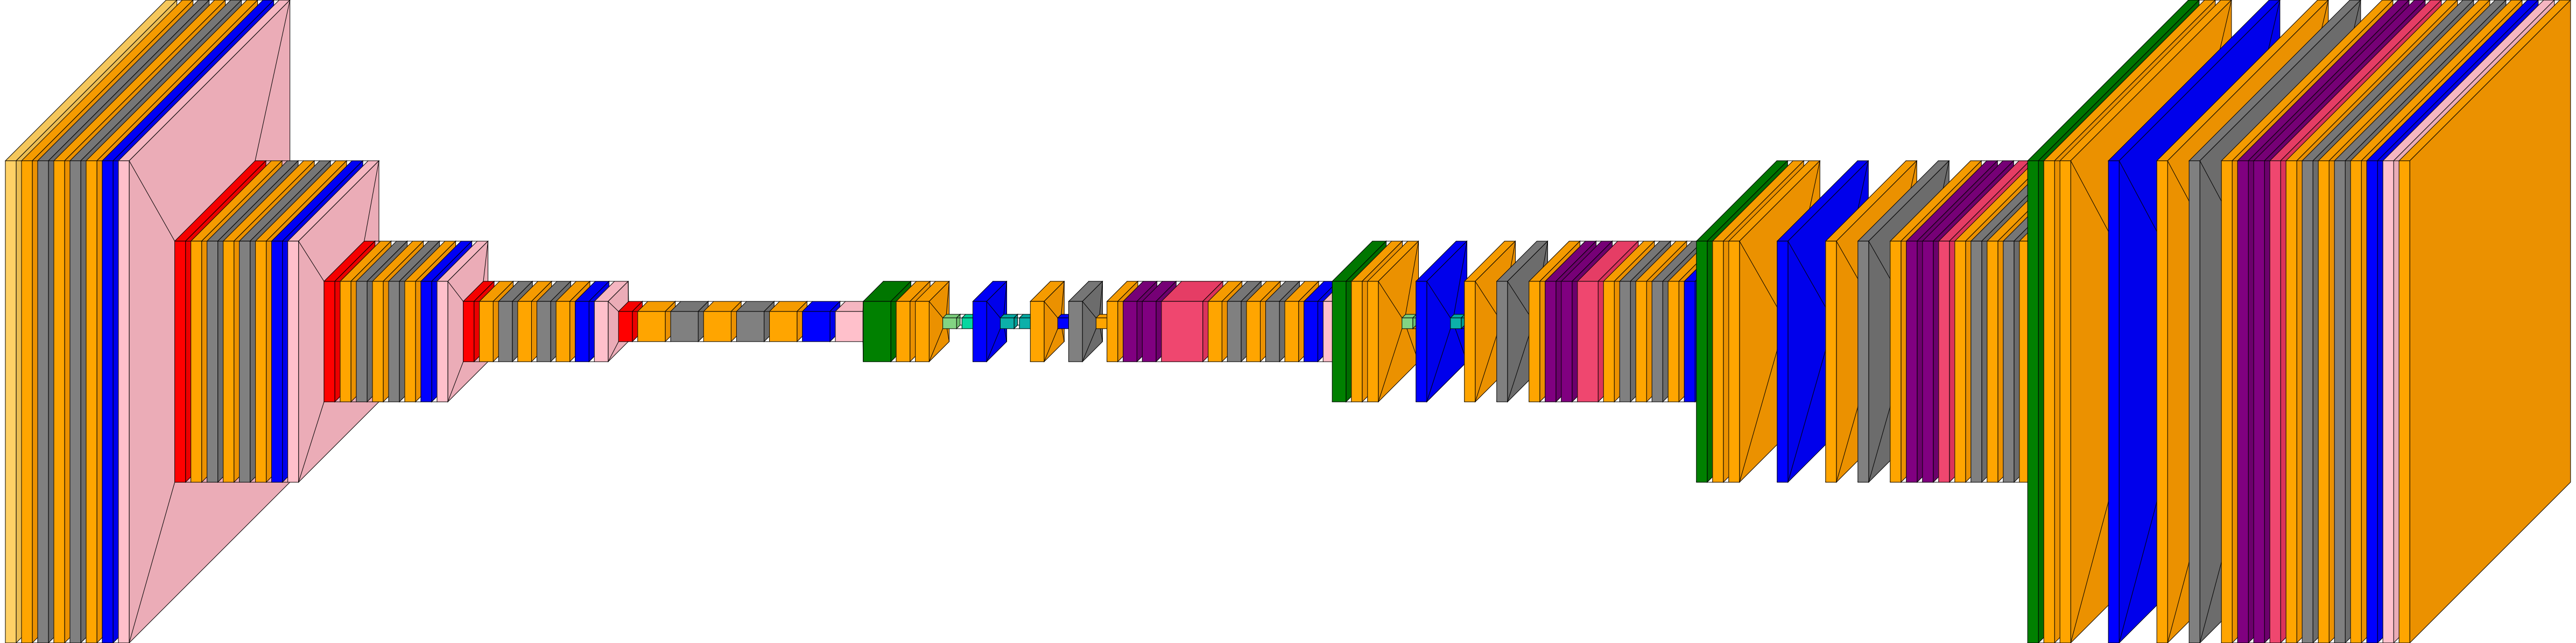

In [4]:
visualkeras.layered_view(sanet_model, to_file='sanet.png', color_map=color_map, type_ignore=[Activation])


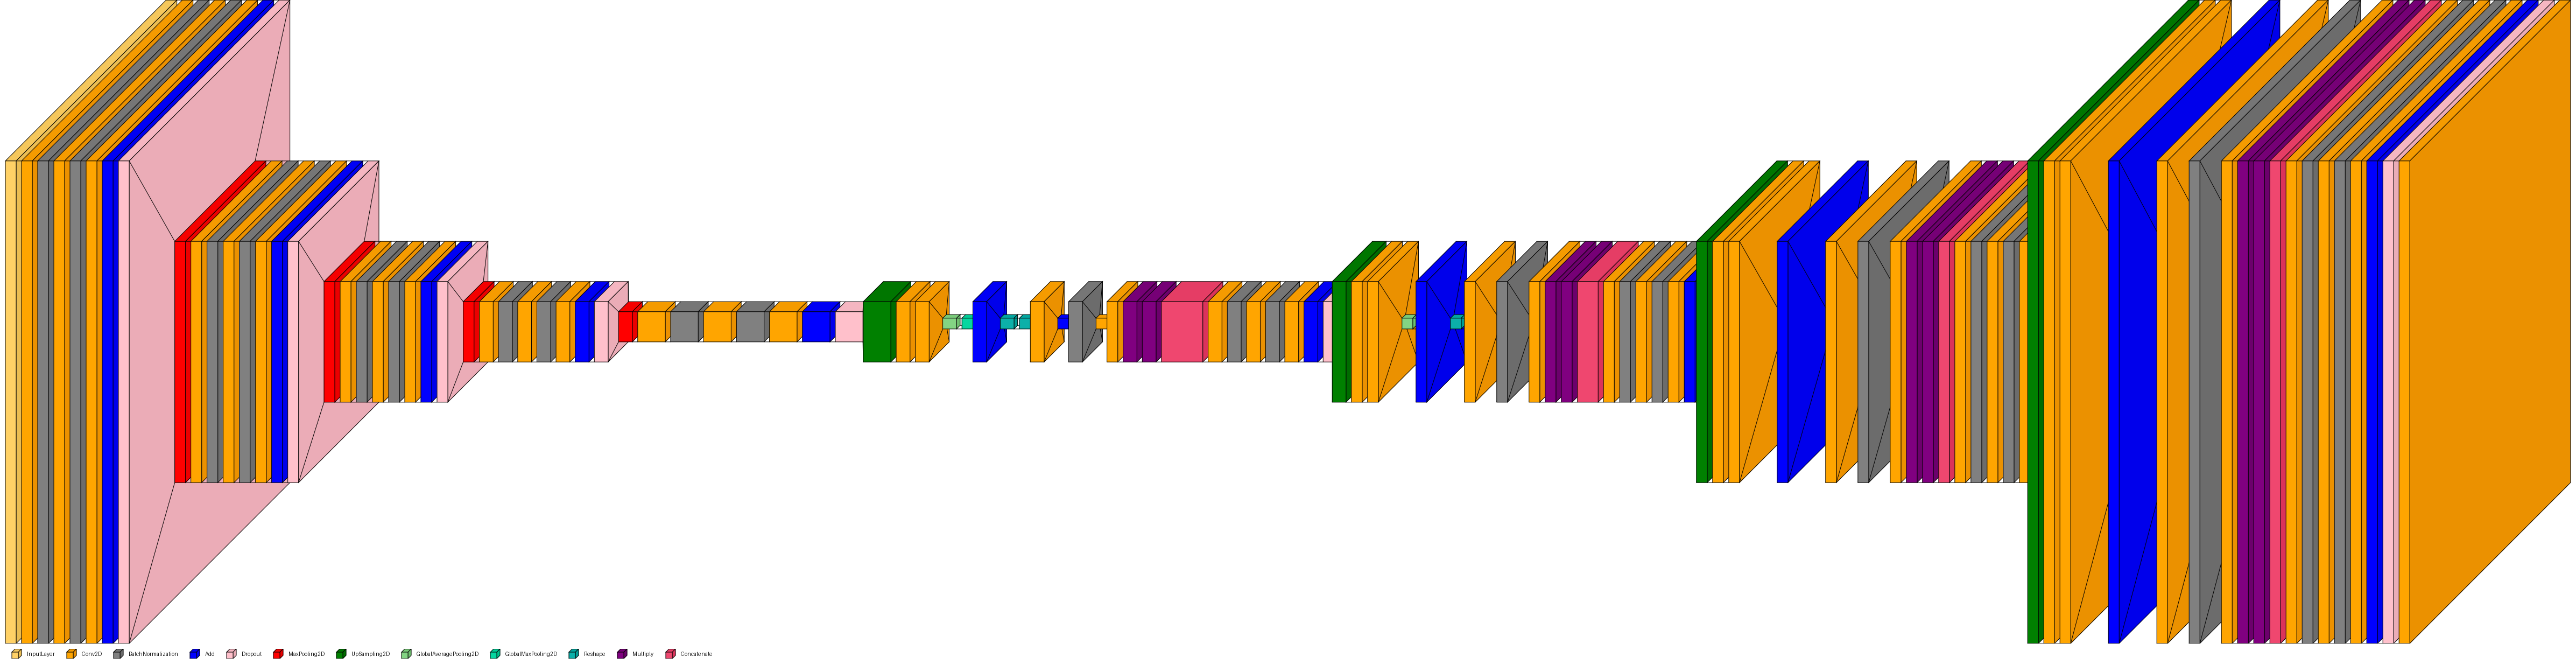

In [5]:
visualkeras.layered_view(sanet_model, to_file='sanet_legend.png', color_map=color_map, type_ignore=[Activation], legend=True, font=font)

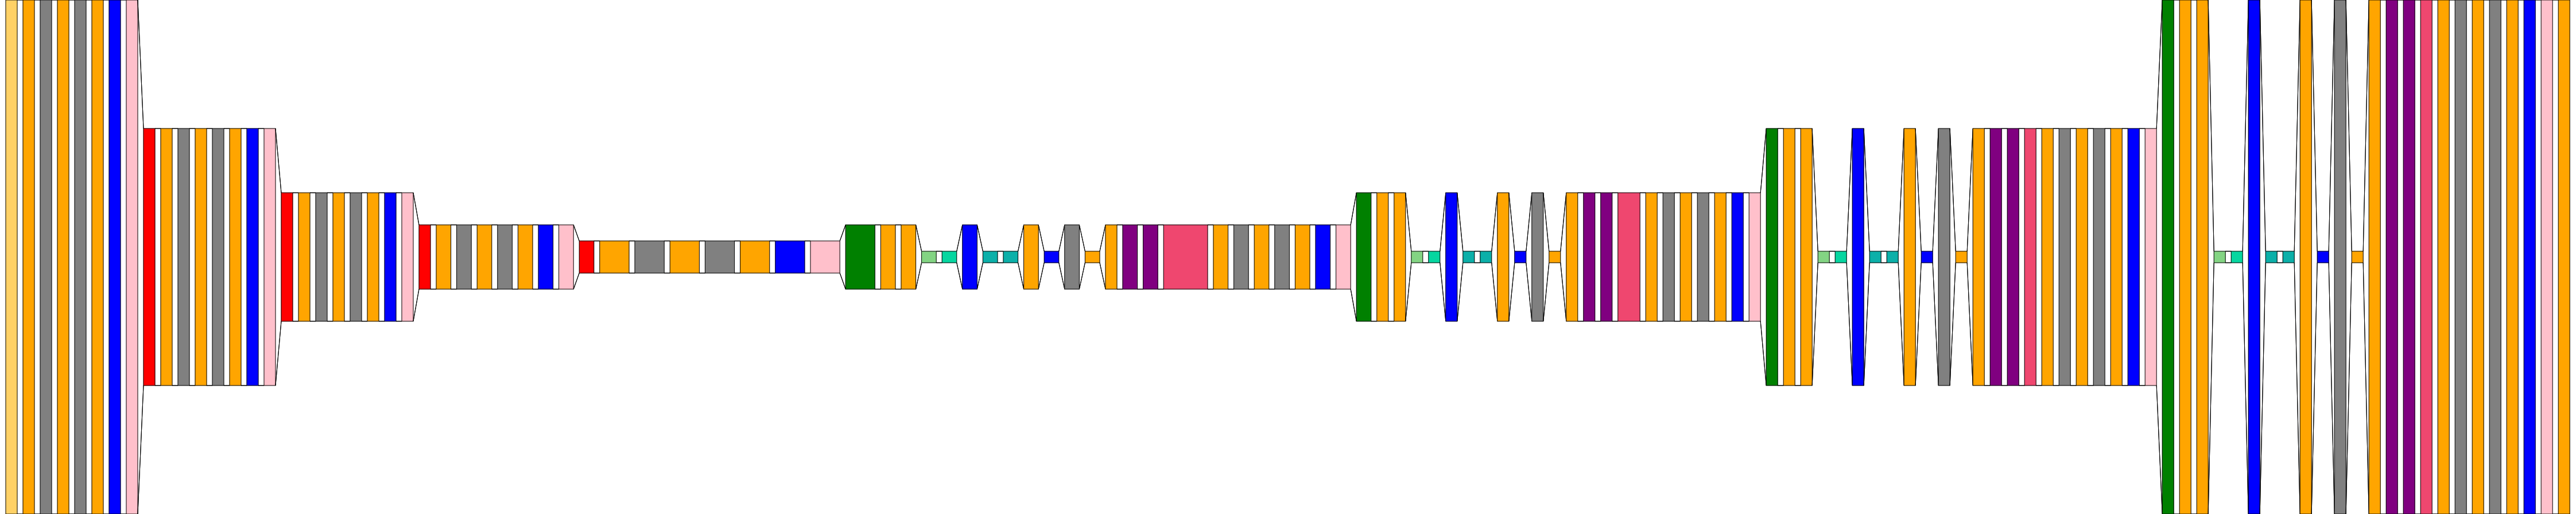

In [6]:
visualkeras.layered_view(sanet_model, to_file='sanet_flat.png', color_map=color_map, type_ignore=[Activation], draw_volume=False)


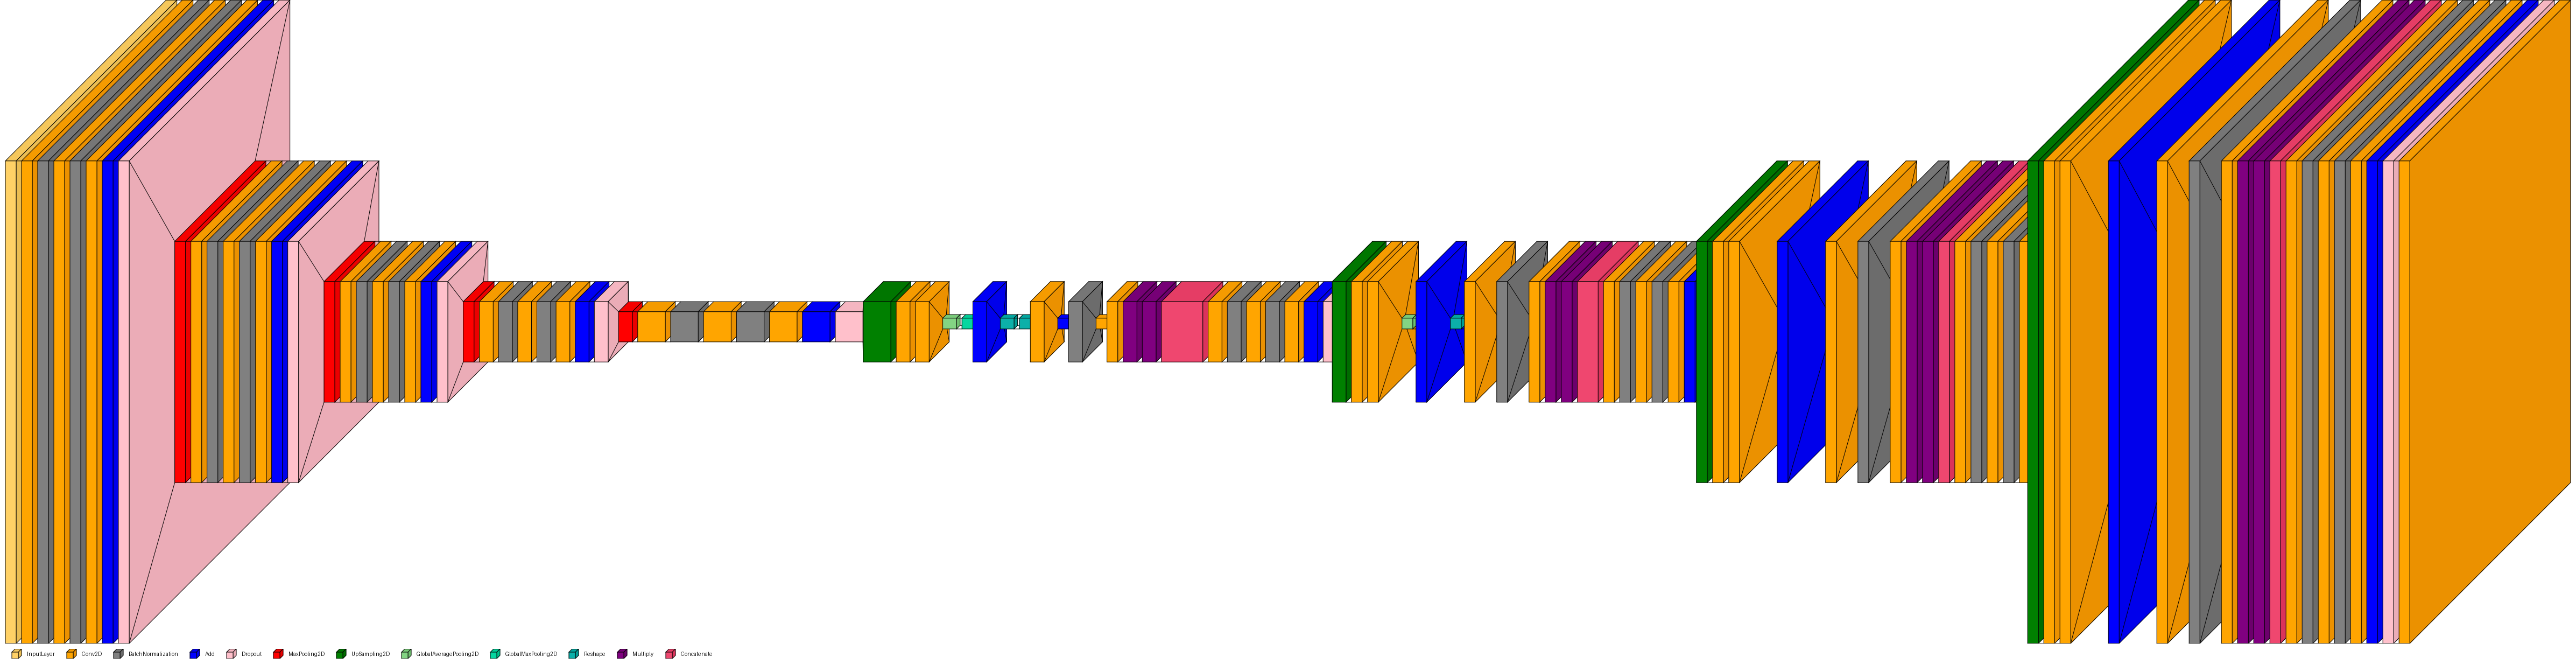

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, Dropout, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Reshape, Multiply, MaxPooling2D, UpSampling2D, concatenate)
from collections import defaultdict
import visualkeras
from PIL import ImageFont, Image

# Enhanced Convolution Block
def enhanced_conv_block(x, filters, ker_init, dropout):
    shortcut = x
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same', kernel_initializer=ker_init)(shortcut)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return Dropout(dropout)(x)

# Enhanced Attention Block
def enhanced_attention_block(x, g, inter_channels):
    avg_pool = GlobalAveragePooling2D()(x)
    max_pool = GlobalMaxPooling2D()(x)
    avg_pool = Reshape((1, 1, inter_channels))(avg_pool)
    max_pool = Reshape((1, 1, inter_channels))(max_pool)
    channel_att = Add()([avg_pool, max_pool])
    channel_att = Conv2D(inter_channels, 1)(channel_att)
    channel_att = Activation('sigmoid')(channel_att)
    theta_x = Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    f = Add()([theta_x, phi_g])
    f = Conv2D(inter_channels, 1, padding='same')(f)
    f = BatchNormalization()(f)
    f = Activation('relu')(f)
    spatial_att = Conv2D(1, 1, padding='same')(f)
    spatial_att = Activation('sigmoid')(spatial_att)
    x = Multiply()([x, channel_att])
    x = Multiply()([x, spatial_att])
    return x

# SANet Model
def build_sanet(inputs, ker_init, dropout):
    conv1 = enhanced_conv_block(inputs, 32, ker_init, dropout)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = enhanced_conv_block(pool1, 64, ker_init, dropout)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = enhanced_conv_block(pool2, 128, ker_init, dropout)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = enhanced_conv_block(pool3, 256, ker_init, dropout)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv5 = enhanced_conv_block(pool4, 512, ker_init, dropout)
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = enhanced_attention_block(conv4, up6, 256)
    merge6 = concatenate([up6, att6])
    conv6 = enhanced_conv_block(merge6, 256, ker_init, dropout)
    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = enhanced_attention_block(conv3, up7, 128)
    merge7 = concatenate([up7, att7])
    conv7 = enhanced_conv_block(merge7, 128, ker_init, dropout)
    up8 = UpSampling2D(size=(2, 2))(conv7)
    att8 = enhanced_attention_block(conv2, up8, 64)
    merge8 = concatenate([up8, att8])
    conv8 = enhanced_conv_block(merge8, 64, ker_init, dropout)
    up9 = UpSampling2D(size=(2, 2))(conv8)
    att9 = enhanced_attention_block(conv1, up9, 32)
    merge9 = concatenate([up9, att9])
    conv9 = enhanced_conv_block(merge9, 32, ker_init, dropout)
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv9)
    return Model(inputs=inputs, outputs=outputs)

# Create the SANet model
inputs = Input(shape=(224, 224, 3))
ker_init = 'he_normal'
dropout = 0.5
sanet_model = build_sanet(inputs, ker_init, dropout)

# Visualization using visualkeras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[BatchNormalization]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Add]['fill'] = 'blue'
color_map[Multiply]['fill'] = 'purple'
color_map[UpSampling2D]['fill'] = 'green'
color_map[concatenate]['fill'] = 'brown'

# Attempt to use the Arial font; fallback if not available
try:
    font = ImageFont.truetype("arial.ttf", 32)
except IOError:
    font = None

# Generate and annotate the visualization
visualkeras.layered_view(sanet_model, to_file='sanet.png', color_map=color_map, type_ignore=[Activation], font=font, legend=True)


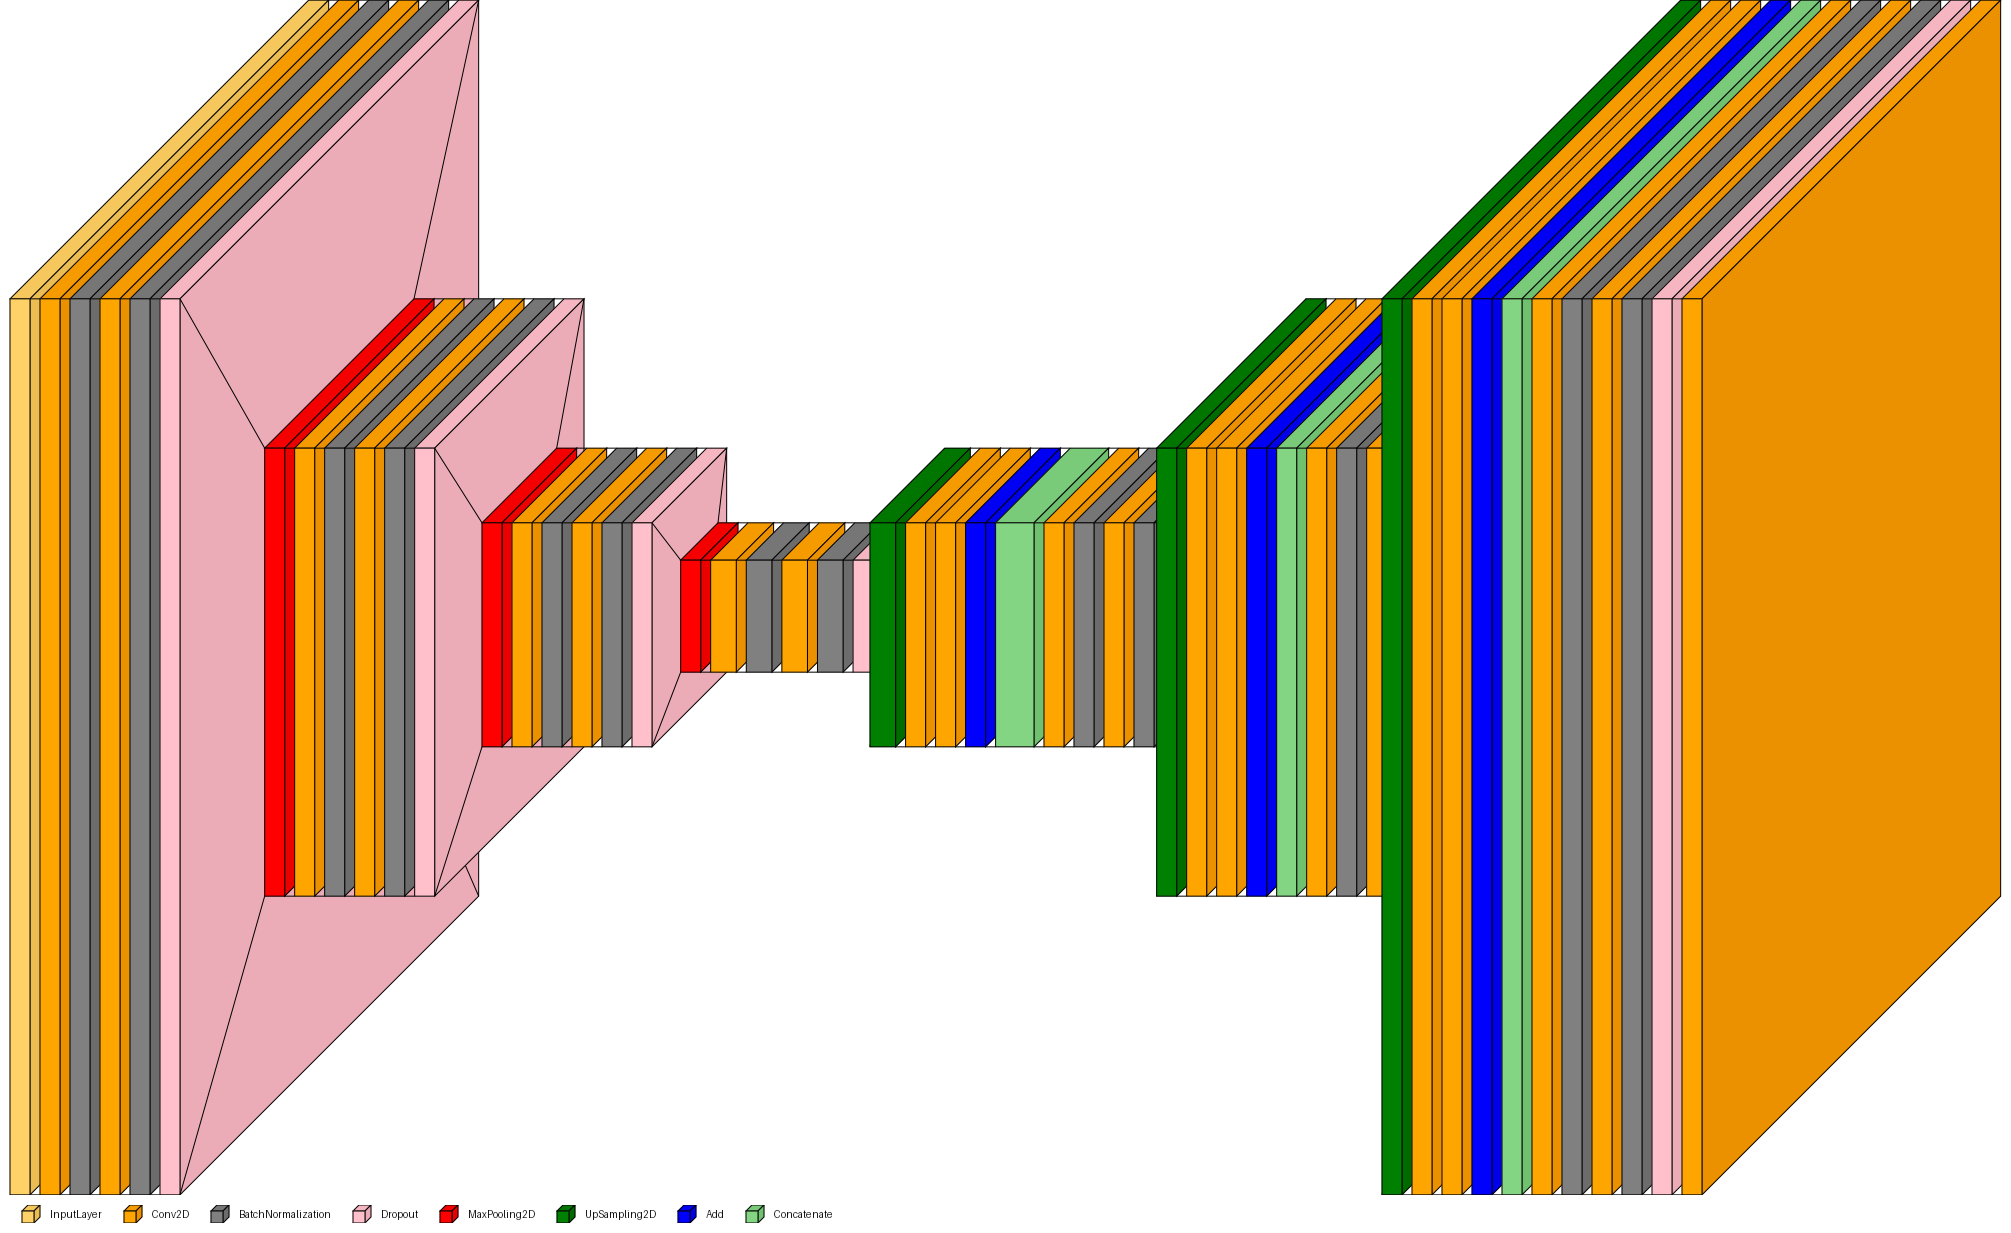

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, Dropout, MaxPooling2D,
                                     UpSampling2D, concatenate)
from collections import defaultdict
import visualkeras
from PIL import ImageFont, Image

# Simple Convolution Block
def simple_conv_block(x, filters, ker_init, dropout):
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    return x

# Simple Attention Block
def simple_attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, 1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, padding='same')(g)
    f = Add()([theta_x, phi_g])
    f = Activation('relu')(f)
    return f

# Small SANet Model
def build_small_sanet(inputs, ker_init, dropout):
    conv1 = simple_conv_block(inputs, 32, ker_init, dropout)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = simple_conv_block(pool1, 64, ker_init, dropout)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = simple_conv_block(pool2, 128, ker_init, dropout)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = simple_conv_block(pool3, 256, ker_init, dropout)
    
    up5 = UpSampling2D(size=(2, 2))(conv4)
    att5 = simple_attention_block(conv3, up5, 128)
    merge5 = concatenate([up5, att5])
    conv5 = simple_conv_block(merge5, 128, ker_init, dropout)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = simple_attention_block(conv2, up6, 64)
    merge6 = concatenate([up6, att6])
    conv6 = simple_conv_block(merge6, 64, ker_init, dropout)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = simple_attention_block(conv1, up7, 32)
    merge7 = concatenate([up7, att7])
    conv7 = simple_conv_block(merge7, 32, ker_init, dropout)
    
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv7)
    
    return Model(inputs=inputs, outputs=outputs)

# Create the small SANet model
inputs = Input(shape=(224, 224, 3))
ker_init = 'he_normal'
dropout = 0.5
small_sanet_model = build_small_sanet(inputs, ker_init, dropout)

# Visualization using visualkeras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[BatchNormalization]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Add]['fill'] = 'blue'
color_map[UpSampling2D]['fill'] = 'green'
color_map[concatenate]['fill'] = 'brown'

# Attempt to use the Arial font; fallback if not available
try:
    font = ImageFont.truetype("arial.ttf", 32)
except IOError:
    font = None

# Generate and annotate the visualization
visualkeras.layered_view(small_sanet_model, to_file='small_sanet.png', color_map=color_map, type_ignore=[Activation], font=font, legend=True)



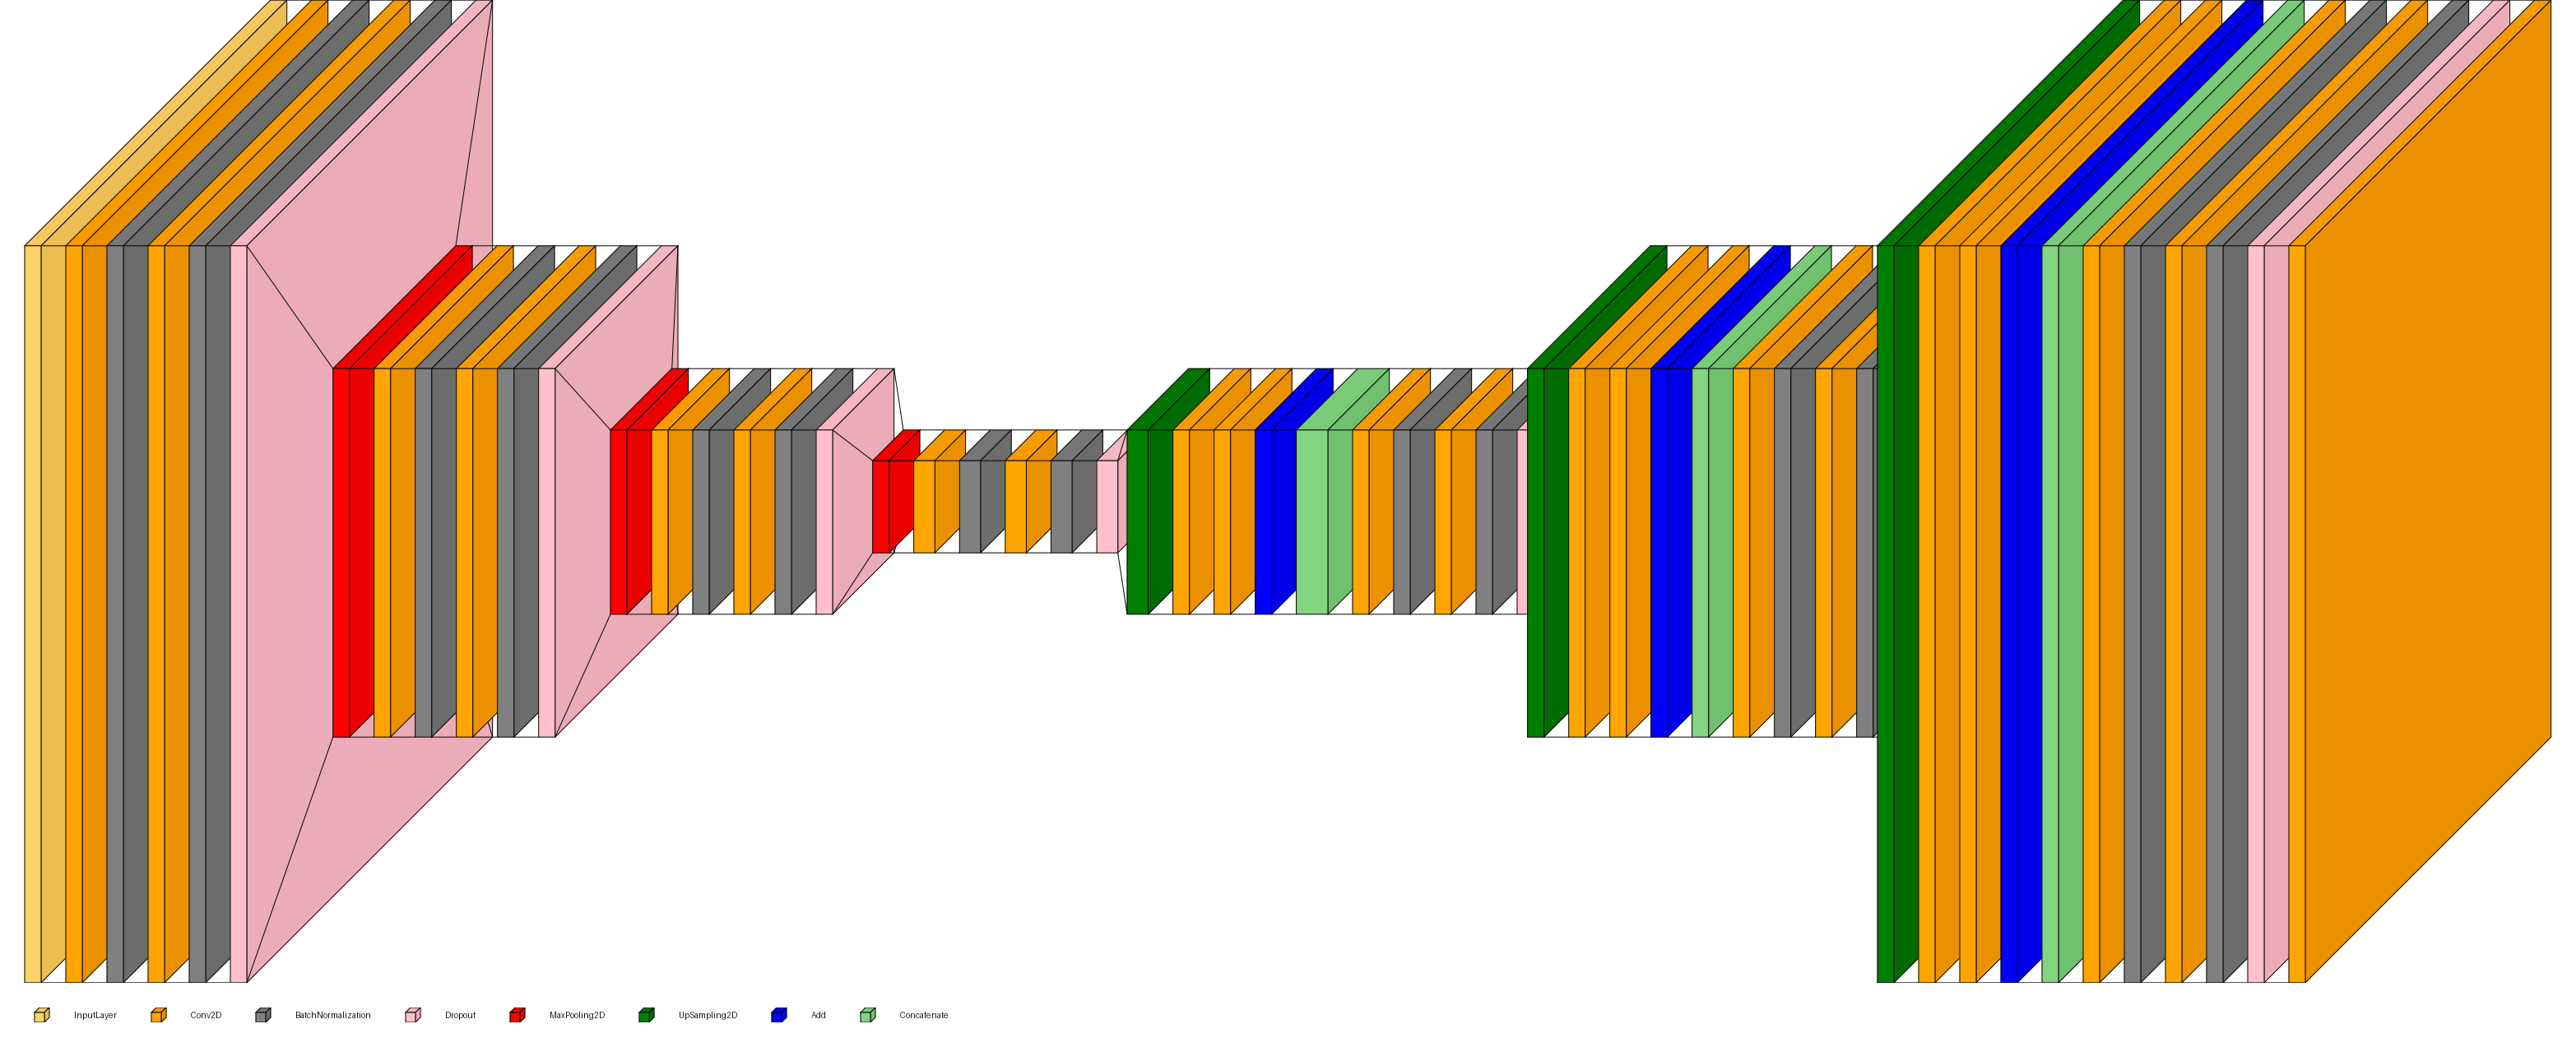

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, Add, Dropout, MaxPooling2D,
                                     UpSampling2D, concatenate)
from collections import defaultdict
import visualkeras
from PIL import ImageFont, Image

# Simple Convolution Block
def simple_conv_block(x, filters, ker_init, dropout):
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout)(x)
    return x

# Simple Attention Block
def simple_attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, 1, padding='same')(x)
    phi_g = Conv2D(inter_channels, 1, padding='same')(g)
    f = Add()([theta_x, phi_g])
    f = Activation('relu')(f)
    return f

# Small SANet Model
def build_small_sanet(inputs, ker_init, dropout):
    # Encoder path
    conv1 = simple_conv_block(inputs, 32, ker_init, dropout)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = simple_conv_block(pool1, 64, ker_init, dropout)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = simple_conv_block(pool2, 128, ker_init, dropout)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = simple_conv_block(pool3, 256, ker_init, dropout)
    
    # Decoder path
    up5 = UpSampling2D(size=(2, 2))(conv4)
    att5 = simple_attention_block(conv3, up5, 128)
    merge5 = concatenate([up5, att5])
    conv5 = simple_conv_block(merge5, 128, ker_init, dropout)
    
    up6 = UpSampling2D(size=(2, 2))(conv5)
    att6 = simple_attention_block(conv2, up6, 64)
    merge6 = concatenate([up6, att6])
    conv6 = simple_conv_block(merge6, 64, ker_init, dropout)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    att7 = simple_attention_block(conv1, up7, 32)
    merge7 = concatenate([up7, att7])
    conv7 = simple_conv_block(merge7, 32, ker_init, dropout)
    
    # Output layer
    outputs = Conv2D(4, (1, 1), activation='softmax')(conv7)
    
    return Model(inputs=inputs, outputs=outputs)

# Create the small SANet model
inputs = Input(shape=(224, 224, 3))
ker_init = 'he_normal'
dropout = 0.5
small_sanet_model = build_small_sanet(inputs, ker_init, dropout)

# Visualization using visualkeras
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[BatchNormalization]['fill'] = 'gray'
color_map[Dropout]['fill'] = 'pink'
color_map[MaxPooling2D]['fill'] = 'red'
color_map[Add]['fill'] = 'blue'
color_map[UpSampling2D]['fill'] = 'green'
color_map[concatenate]['fill'] = 'brown'

# Attempt to use the Arial font; fallback if not available
try:
    font = ImageFont.truetype("arial.ttf", 40)
except IOError:
    font = None

# Generate and annotate the visualization with larger text and gaps
visualkeras.layered_view(small_sanet_model, to_file='small_sanet_paper.png', color_map=color_map, type_ignore=[Activation], font=font, legend=True, spacing=30, padding=30)
